In [63]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

import IPython.display as ipd
#import os
#model_dir = "/".join(os.getcwd().split("/")[:-1] + ['models/'])
model_dir = "./models/"
import models
from utils import test_accuracy, train_epoch, show_weights, model_prune, print_dims, get_weight_penalty, prune_plot
import copy
from tensorboardX import SummaryWriter

writeTensorboard = False
if(writeTensorboard):
    writer = SummaryWriter('tensorboard/run1/')

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")


#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_data_full = Variable(train_dataset.train_data.float()/255.0).cuda()
test_data_full = Variable(test_dataset.test_data.float()/255.0).cuda()
train_labels_full = Variable(train_dataset.train_labels).cuda()
test_labels_full = Variable(test_dataset.test_labels).cuda()
use_cuda = torch.cuda.is_available()

#arguments
model_name = 'LeNet_300_100'
training_epochs=20
retraining_epochs=50
temp_list = [1, 5, 10, 15, 20, 25, 30]

## LeNet 300-100

### 1. Train Model

In [49]:
def trueAfterN(ip, N):
    return ((N-1)==ip%N)

In [107]:
gmp.gammas.data.clone().cpu().numpy()

array([5.8591104, 5.610733 , 6.5668254, 5.5610023, 6.5873113, 5.749625 ,
       6.336213 , 6.5300326, 6.5253158, 6.5291634, 6.380212 , 6.4648657,
       6.4622707, 6.5271144, 6.5845413, 6.5447183], dtype=float32)

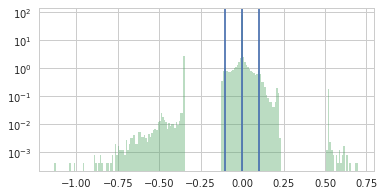

In [103]:
def show_sws_weights(model, means, precisions):
    weights = np.array([], dtype=np.float32)
    for layer in model.state_dict():
        weights = np.hstack( (weights, model.state_dict()[layer].view(-1).cpu().numpy()) )
    plt.clf()
    plt.figure(figsize=(6, 3))
    sns.distplot(weights, kde=False, color="g",bins=200,norm_hist=True, hist_kws={'log':True})
    plt.axvline(0)
    for mean in means:
        plt.axvline(mean)
    plt.show()
    
show_sws_weights(model, [-0.1, 0, 0.1], [0.2, 0.3, 0.1])

In [101]:
for i in gmp.means:
    print (i)

Variable containing:
-0.6015
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
-0.5144
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
-0.4267
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
-0.3442
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
-0.2586
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
-0.1724
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
 -8.6526
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-04 *
 -3.3383
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
1.00000e-02 *
  8.6649
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1725
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2582
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.3418
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.4290
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variab

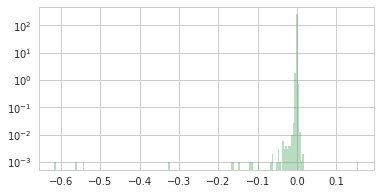

In [50]:
def show_all_weights(model):
    weights = np.array([], dtype=np.float32)
    for layer in model.state_dict():
        weights = np.hstack( (weights, model.state_dict()[layer].view(-1).cpu().numpy()) )
    plt.clf()
    plt.figure(figsize=(6, 3))
    sns.distplot(weights, kde=False, color="g",bins=200,norm_hist=True, hist_kws={'log':True})
    plt.show()
    
show_all_weights(model)

In [51]:
def show_weights(model):
    weight_list = [x for x in model.state_dict().keys() if 'weight' in x]
    plt.clf()
    plt.figure(figsize=(18, 3))
    for i,weight in enumerate(weight_list):
        plt.subplot(131 + i)
        fc_w = model.state_dict()[weight]
        sns.distplot(fc_w.view(-1).cpu().numpy(), kde=False, color="g",bins=200,norm_hist=True)
        plt.title('Layer: {}'.format(weight))
    plt.show()
    
#show_weights(model)

In [90]:
def logsumexp(t, w=1, axis=1):
    #print (t.shape)
    t_max, _ = t.max(dim=1)
    if (axis==1):
        t = t-t_max.repeat(t.size(1), 1).t()
    else:
        t = t-t_max.repeat(1, t.size(0)).t()
    t = w * t.exp()
    t = t.sum(dim=axis)
    t.log_()
    return t + t_max

class GaussianMixturePrior(Module):
    def __init__(self, nb_components, network_weights, pi_zero, **kwargs):
        super(GaussianMixturePrior, self).__init__()
        
        self.nb_components = nb_components 
        self.network_weights = [p.view(-1) for p in network_weights]
        self.pi_zero = pi_zero
        
        #Build
        J = self.nb_components
        pi_zero = self.pi_zero
        
        #    ... means
        init_means = torch.linspace(-0.6, 0.6, J - 1)
        self.means = Variable(init_means.cuda(), requires_grad=True)
        
        #precision
        init_stds = torch.FloatTensor(np.tile(0.05, J) )
        self.gammas = Variable( (- torch.log(torch.pow(init_stds, 2))).cuda(), requires_grad=True)
        
        #mixing proportions
        init_mixing_proportions = torch.ones((J - 1))
        init_mixing_proportions *= (1. - pi_zero) / (J - 1)
        self.rhos = Variable((init_mixing_proportions).cuda(), requires_grad=True)
        self.print_batch=True
        #self.loss = Variable(torch.cuda.FloatTensor([0.]), requires_grad=True)
        
    def call(self, mask=None):
        J=self.nb_components
        loss = Variable(torch.cuda.FloatTensor([0.]), requires_grad=True)
        means = torch.cat(( Variable(torch.cuda.FloatTensor([0.]), requires_grad=True) , self.means), 0)
        #mean=self.means
        precision = self.gammas.exp()
        
        min_rho = self.rhos.min()
        mixing_proportions = (self.rhos - min_rho).exp()
        mixing_proportions = (1 - self.pi_zero) * mixing_proportions/mixing_proportions.sum()
        mixing_proportions = torch.pow(mixing_proportions, 2)
        mixing_proportions = torch.cat(( Variable(torch.cuda.FloatTensor([self.pi_zero])) , mixing_proportions), 0)
        
        for weights in self.network_weights:
            weight_loss = self.compute_loss(weights, mixing_proportions, means, precision)
            if(gmp.print_batch):
                print ("Layer Loss: {:.3f}".format(float(weight_loss.data)))
            loss = loss + weight_loss
        
        
        # GAMMA PRIOR ON PRECISION
        # ... for the zero component
        
        #Replacing gather with indexing -- same calculation?
        (alpha, beta) = (5e3,20e-1)
        #print (torch.gather(self.gammas, 0, Variable(torch.cuda.LongTensor([0,1,2]))))
        neglogprop = (1 - alpha) * self.gammas[0] + beta * precision[0]
        if(gmp.print_batch):
            print ("0-neglogprop Loss: {:.3f}".format(float(neglogprop.data)))
        loss = loss + neglogprop.sum()
        # ... and all other component
        alpha, beta = (2.5e2,1e-1)
        neglogprop = (1 - alpha) * self.gammas[1:J] + beta * precision[1:J]
        if(gmp.print_batch):
            print ("Remaining-neglogprop Loss: {:.3f}".format(float(neglogprop.sum().data)))
        loss = loss + neglogprop.sum()
        gmp.print_batch=False
        return loss
        
        
    def compute_loss(self, weights, mixing_proportions, means, precision):
        diff = weights.expand(means.size(0), -1) - means.expand(weights.size(0), -1).t()
        unnormalized_log_likelihood = (-(diff ** 2)/2).t() * precision
        #unnormalized_log_likelihood = (-1/2) * precision.matmul((diff ** 2))
        Z = precision.sqrt() / (2 * np.pi)
        #global myt
        #myt=unnormalized_log_likelihood
        log_likelihood = logsumexp(unnormalized_log_likelihood, w=(mixing_proportions * Z), axis=1)
        return -log_likelihood.sum()

In [91]:
def train_epoch_sws(model, optimizer, optimizer_gmp, optimizer_gmp2, criterion, train_loader):
    """
    train model
    
    model: neural network model
    optimizer: optimization algorithm/configuration
    criterion: loss function
    train_loader: training dataset dataloader
    """
    model.train()
    gmp.print_batch = True
    for i, (images, labels) in enumerate(train_loader):
        #if(use_cuda):
        images=images.cuda()
        labels=labels.cuda()
        images = Variable(images)
        labels = Variable(labels)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        optimizer_gmp.zero_grad()
        optimizer_gmp2.zero_grad()
        # Forward pass to get output/logits
        outputs = model(images)
        # Calculate Loss: softmax --> cross entropy loss
        #loss = criterion(outputs, labels) + 0.001 * ( (model.fc1.weight - 0.05).norm() + (model.fc2.weight - 0.05).norm() + (model.fc3.weight - 0.05).norm() + (model.fc1.weight + 0.05).norm() + (model.fc2.weight + 0.05).norm() + (model.fc3.weight + 0.05).norm())
        loss = criterion(outputs, labels)
        #print (criterion(outputs, labels))
        #print (gmp.call())
        # Getting gradients w.r.t. parameters
        gmp_loss = gmp.call()
        loss.backward()
        gmp_loss.backward()
        # Updating parameters
        optimizer.step()
        optimizer_gmp.step()
        optimizer_gmp2.step()
    return model, criterion(outputs, labels)

**Default Training**

**Epoch: 0**

Layer Loss: 32393.455
Layer Loss: -164.616
Layer Loss: 23299.031
Layer Loss: 19.565
Layer Loss: 2681.028
Layer Loss: -4.651
0-neglogprop Loss: -28264.064
Remaining-neglogprop Loss: -22270.555
Epoch: 1. Loss: 1.471584439277649. Accuracy: 97.64
Means: [-0.601, -0.514, -0.428, -0.343, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.428, 0.514, 0.599]
Mixing Proportions: [-0.185, -0.28, 0.283, 0.283, 0.077, -0.242, -0.226, -0.225, -0.226, -0.236, 0.06, 0.167, -0.346, -0.2, -0.218]
Precisions: [5.775, 5.773, 6.298, 5.808, 6.315, 5.896, 6.076, 6.273, 6.268, 6.272, 6.118, 6.189, 6.254, 6.258, 6.319, 6.281]


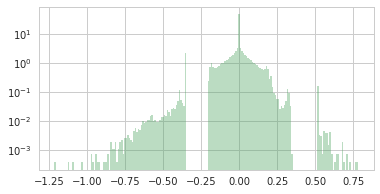

**Epoch: 1**

Layer Loss: 22872.816
Layer Loss: -173.474
Layer Loss: 21733.871
Layer Loss: 13.422
Layer Loss: 2612.449
Layer Loss: -5.033
0-neglogprop Loss: -28224.979
Remaining-neglogprop Loss: -22286.100
Epoch: 2. Loss: 1.4736195802688599. Accuracy: 97.55
Means: [-0.601, -0.514, -0.428, -0.343, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.428, 0.514, 0.599]
Mixing Proportions: [-0.194, -0.289, 0.292, 0.292, 0.068, -0.251, -0.235, -0.234, -0.235, -0.245, 0.051, 0.158, -0.355, -0.209, -0.227]
Precisions: [5.766, 5.764, 6.307, 5.799, 6.324, 5.887, 6.085, 6.282, 6.277, 6.281, 6.127, 6.198, 6.263, 6.267, 6.328, 6.29]


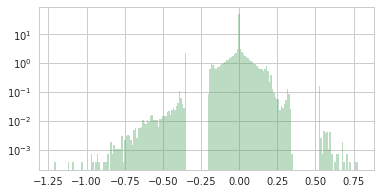

**Epoch: 2**

Layer Loss: 13900.287
Layer Loss: -181.640
Layer Loss: 20247.449
Layer Loss: 7.597
Layer Loss: 2546.872
Layer Loss: -5.391
0-neglogprop Loss: -28186.307
Remaining-neglogprop Loss: -22301.604
Epoch: 3. Loss: 1.4750093221664429. Accuracy: 97.52
Means: [-0.601, -0.514, -0.428, -0.343, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.428, 0.514, 0.599]
Mixing Proportions: [-0.203, -0.298, 0.301, 0.301, 0.059, -0.26, -0.244, -0.243, -0.243, -0.254, 0.042, 0.148, -0.364, -0.218, -0.236]
Precisions: [5.757, 5.756, 6.316, 5.79, 6.333, 5.878, 6.094, 6.291, 6.286, 6.29, 6.136, 6.207, 6.272, 6.276, 6.337, 6.299]


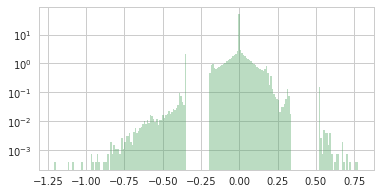

**Epoch: 3**

Layer Loss: 5460.536
Layer Loss: -189.170
Layer Loss: 18837.543
Layer Loss: 2.087
Layer Loss: 2484.289
Layer Loss: -5.723
0-neglogprop Loss: -28148.506
Remaining-neglogprop Loss: -22317.078
Epoch: 4. Loss: 1.4770334959030151. Accuracy: 97.45
Means: [-0.601, -0.514, -0.427, -0.343, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.428, 0.514, 0.599]
Mixing Proportions: [-0.212, -0.307, 0.31, 0.31, 0.05, -0.269, -0.252, -0.252, -0.252, -0.263, 0.033, 0.139, -0.373, -0.227, -0.245]
Precisions: [5.749, 5.747, 6.325, 5.781, 6.342, 5.869, 6.103, 6.3, 6.295, 6.299, 6.145, 6.216, 6.281, 6.286, 6.346, 6.308]


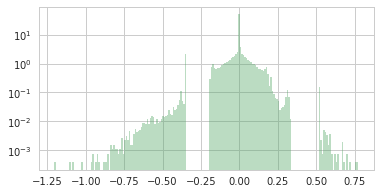

**Epoch: 4**

Layer Loss: -2478.118
Layer Loss: -196.118
Layer Loss: 17500.258
Layer Loss: -3.117
Layer Loss: 2424.653
Layer Loss: -6.031
0-neglogprop Loss: -28112.086
Remaining-neglogprop Loss: -22332.535
Epoch: 5. Loss: 1.4790242910385132. Accuracy: 97.34
Means: [-0.601, -0.514, -0.427, -0.343, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.428, 0.514, 0.599]
Mixing Proportions: [-0.221, -0.316, 0.319, 0.319, 0.041, -0.278, -0.261, -0.261, -0.261, -0.272, 0.024, 0.129, -0.382, -0.236, -0.254]
Precisions: [5.741, 5.738, 6.334, 5.772, 6.351, 5.861, 6.112, 6.309, 6.304, 6.308, 6.154, 6.225, 6.289, 6.295, 6.355, 6.317]


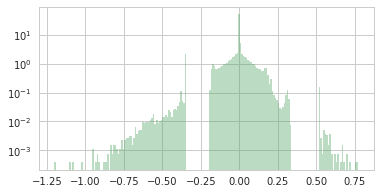

**Epoch: 5**

Layer Loss: -9934.074
Layer Loss: -202.515
Layer Loss: 16232.741
Layer Loss: -8.020
Layer Loss: 2367.925
Layer Loss: -6.317
0-neglogprop Loss: -28077.590
Remaining-neglogprop Loss: -22347.990
Epoch: 6. Loss: 1.4818401336669922. Accuracy: 97.24
Means: [-0.601, -0.514, -0.427, -0.343, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.428, 0.514, 0.599]
Mixing Proportions: [-0.23, -0.325, 0.328, 0.328, 0.032, -0.287, -0.27, -0.27, -0.27, -0.281, 0.015, 0.119, -0.391, -0.244, -0.263]
Precisions: [5.734, 5.73, 6.343, 5.763, 6.36, 5.852, 6.121, 6.318, 6.313, 6.317, 6.163, 6.235, 6.298, 6.304, 6.364, 6.326]


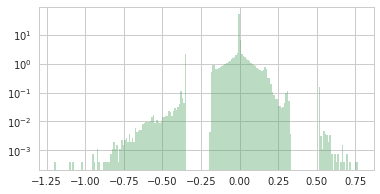

**Epoch: 6**

Layer Loss: -16945.096
Layer Loss: -208.416
Layer Loss: 15030.206
Layer Loss: -12.633
Layer Loss: 2314.010
Layer Loss: -6.583
0-neglogprop Loss: -28045.586
Remaining-neglogprop Loss: -22363.443
Epoch: 7. Loss: 1.484931230545044. Accuracy: 97.19
Means: [-0.601, -0.514, -0.427, -0.343, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.428, 0.514, 0.599]
Mixing Proportions: [-0.24, -0.334, 0.337, 0.337, 0.022, -0.296, -0.279, -0.279, -0.279, -0.29, 0.006, 0.109, -0.399, -0.253, -0.272]
Precisions: [5.727, 5.721, 6.352, 5.754, 6.369, 5.844, 6.13, 6.327, 6.322, 6.326, 6.172, 6.244, 6.306, 6.313, 6.373, 6.335]


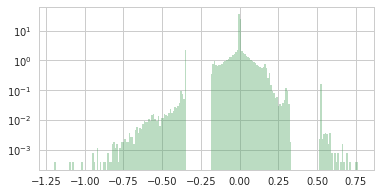

**Epoch: 7**

Layer Loss: -23540.727
Layer Loss: -213.868
Layer Loss: 13888.499
Layer Loss: -16.966
Layer Loss: 2262.813
Layer Loss: -6.831
0-neglogprop Loss: -28016.656
Remaining-neglogprop Loss: -22378.902
Epoch: 8. Loss: 1.4888943433761597. Accuracy: 97.13
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.428, 0.514, 0.599]
Mixing Proportions: [-0.249, -0.343, 0.346, 0.346, 0.013, -0.304, -0.288, -0.288, -0.288, -0.299, -0.003, 0.099, -0.408, -0.261, -0.28]
Precisions: [5.722, 5.713, 6.361, 5.744, 6.379, 5.836, 6.139, 6.336, 6.331, 6.335, 6.181, 6.254, 6.313, 6.322, 6.382, 6.344]


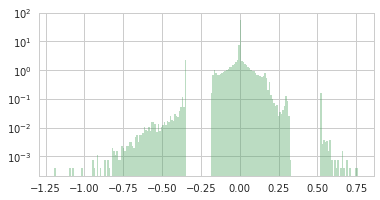

**Epoch: 8**

Layer Loss: -29758.682
Layer Loss: -218.929
Layer Loss: 12802.838
Layer Loss: -21.037
Layer Loss: 2214.213
Layer Loss: -7.064
0-neglogprop Loss: -27991.383
Remaining-neglogprop Loss: -22394.381
Epoch: 9. Loss: 1.4946990013122559. Accuracy: 97.07
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.428, 0.514, 0.599]
Mixing Proportions: [-0.258, -0.352, 0.355, 0.355, 0.004, -0.313, -0.297, -0.297, -0.297, -0.308, -0.012, 0.088, -0.417, -0.269, -0.289]
Precisions: [5.717, 5.706, 6.37, 5.735, 6.388, 5.828, 6.148, 6.345, 6.34, 6.344, 6.19, 6.264, 6.321, 6.332, 6.391, 6.353]


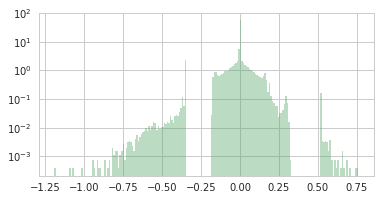

**Epoch: 9**

Layer Loss: -35633.082
Layer Loss: -223.650
Layer Loss: 11768.976
Layer Loss: -24.866
Layer Loss: 2168.085
Layer Loss: -7.283
0-neglogprop Loss: -27970.322
Remaining-neglogprop Loss: -22409.885
Epoch: 10. Loss: 1.4999172687530518. Accuracy: 96.94
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.428, 0.514, 0.599]
Mixing Proportions: [-0.268, -0.361, 0.363, 0.365, -0.006, -0.322, -0.306, -0.306, -0.306, -0.317, -0.021, 0.077, -0.426, -0.277, -0.298]
Precisions: [5.713, 5.698, 6.379, 5.726, 6.397, 5.82, 6.157, 6.353, 6.349, 6.353, 6.199, 6.274, 6.328, 6.341, 6.4, 6.362]


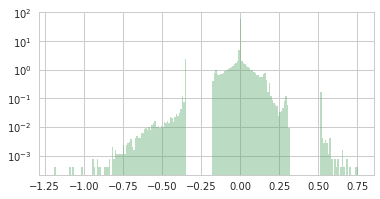

**Epoch: 10**

Layer Loss: -41200.422
Layer Loss: -228.087
Layer Loss: 10782.809
Layer Loss: -28.471
Layer Loss: 2124.291
Layer Loss: -7.489
0-neglogprop Loss: -27953.998
Remaining-neglogprop Loss: -22425.428
Epoch: 11. Loss: 1.5066499710083008. Accuracy: 96.84
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.428, 0.514, 0.598]
Mixing Proportions: [-0.277, -0.37, 0.372, 0.374, -0.015, -0.331, -0.314, -0.314, -0.314, -0.325, -0.03, 0.066, -0.435, -0.285, -0.307]
Precisions: [5.711, 5.691, 6.388, 5.717, 6.406, 5.813, 6.166, 6.362, 6.358, 6.362, 6.208, 6.284, 6.335, 6.351, 6.409, 6.371]


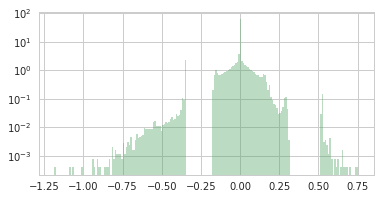

**Epoch: 11**

Layer Loss: -46494.402
Layer Loss: -232.291
Layer Loss: 9840.782
Layer Loss: -31.870
Layer Loss: 2082.683
Layer Loss: -7.684
0-neglogprop Loss: -27942.877
Remaining-neglogprop Loss: -22441.014
Epoch: 12. Loss: 1.512848138809204. Accuracy: 96.77
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.428, 0.514, 0.598]
Mixing Proportions: [-0.287, -0.379, 0.381, 0.383, -0.024, -0.339, -0.323, -0.323, -0.323, -0.334, -0.039, 0.055, -0.444, -0.292, -0.316]
Precisions: [5.709, 5.684, 6.398, 5.708, 6.415, 5.806, 6.175, 6.371, 6.367, 6.37, 6.217, 6.294, 6.341, 6.36, 6.418, 6.38]


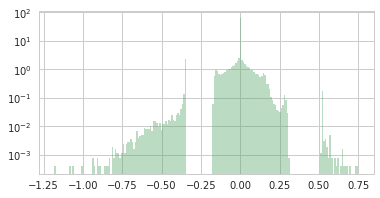

**Epoch: 12**

Layer Loss: -51548.695
Layer Loss: -236.309
Layer Loss: 8939.536
Layer Loss: -35.085
Layer Loss: 2043.100
Layer Loss: -7.868
0-neglogprop Loss: -27937.340
Remaining-neglogprop Loss: -22456.652
Epoch: 13. Loss: 1.5230284929275513. Accuracy: 96.7
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.428, 0.515, 0.598]
Mixing Proportions: [-0.297, -0.388, 0.389, 0.392, -0.034, -0.348, -0.332, -0.332, -0.332, -0.343, -0.049, 0.044, -0.452, -0.299, -0.325]
Precisions: [5.709, 5.677, 6.407, 5.699, 6.425, 5.799, 6.184, 6.38, 6.376, 6.379, 6.226, 6.304, 6.348, 6.369, 6.427, 6.389]


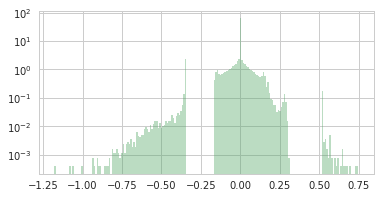

**Epoch: 13**

Layer Loss: -56394.449
Layer Loss: -240.184
Layer Loss: 8075.938
Layer Loss: -38.134
Layer Loss: 2005.376
Layer Loss: -8.045
0-neglogprop Loss: -27937.660
Remaining-neglogprop Loss: -22472.363
Epoch: 14. Loss: 1.5310760736465454. Accuracy: 96.54
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.428, 0.515, 0.598]
Mixing Proportions: [-0.306, -0.397, 0.398, 0.401, -0.043, -0.357, -0.34, -0.34, -0.34, -0.351, -0.059, 0.032, -0.461, -0.306, -0.333]
Precisions: [5.711, 5.671, 6.416, 5.689, 6.434, 5.793, 6.193, 6.389, 6.384, 6.388, 6.236, 6.314, 6.354, 6.379, 6.436, 6.398]


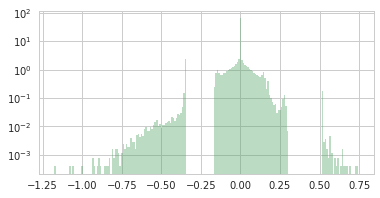

**Epoch: 14**

Layer Loss: -61061.402
Layer Loss: -243.951
Layer Loss: 7246.830
Layer Loss: -41.039
Layer Loss: 1969.335
Layer Loss: -8.214
0-neglogprop Loss: -27943.959
Remaining-neglogprop Loss: -22488.154
Epoch: 15. Loss: 1.5420854091644287. Accuracy: 96.43
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.086, -0.001, 0.086, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.316, -0.406, 0.406, 0.411, -0.053, -0.365, -0.349, -0.349, -0.349, -0.36, -0.068, 0.021, -0.47, -0.313, -0.342]
Precisions: [5.714, 5.665, 6.426, 5.68, 6.443, 5.787, 6.202, 6.398, 6.393, 6.397, 6.245, 6.324, 6.36, 6.388, 6.446, 6.406]


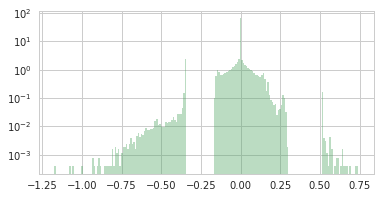

**Epoch: 15**

Layer Loss: -65576.477
Layer Loss: -247.641
Layer Loss: 6449.044
Layer Loss: -43.817
Layer Loss: 1934.801
Layer Loss: -8.378
0-neglogprop Loss: -27956.219
Remaining-neglogprop Loss: -22504.035
Epoch: 16. Loss: 1.5549756288528442. Accuracy: 96.29
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.086, -0.001, 0.087, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.326, -0.415, 0.415, 0.42, -0.063, -0.374, -0.358, -0.357, -0.357, -0.368, -0.078, 0.009, -0.478, -0.319, -0.351]
Precisions: [5.718, 5.659, 6.435, 5.671, 6.453, 5.781, 6.211, 6.407, 6.402, 6.406, 6.254, 6.334, 6.367, 6.398, 6.455, 6.415]


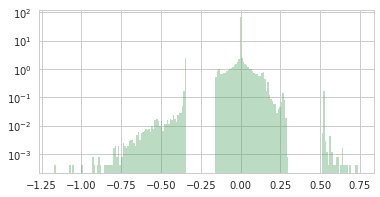

**Epoch: 16**

Layer Loss: -69963.602
Layer Loss: -251.276
Layer Loss: 5679.388
Layer Loss: -46.486
Layer Loss: 1901.605
Layer Loss: -8.536
0-neglogprop Loss: -27974.250
Remaining-neglogprop Loss: -22520.021
Epoch: 17. Loss: 1.5713297128677368. Accuracy: 96.13
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.086, -0.001, 0.087, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.337, -0.424, 0.423, 0.429, -0.073, -0.382, -0.366, -0.366, -0.366, -0.377, -0.088, -0.002, -0.487, -0.325, -0.359]
Precisions: [5.723, 5.654, 6.445, 5.662, 6.462, 5.776, 6.22, 6.416, 6.411, 6.415, 6.263, 6.344, 6.373, 6.407, 6.464, 6.424]


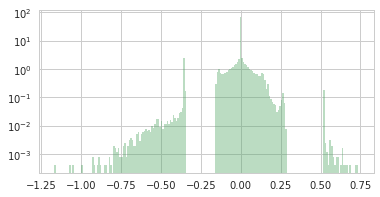

**Epoch: 17**

Layer Loss: -74243.461
Layer Loss: -254.873
Layer Loss: 4934.688
Layer Loss: -49.060
Layer Loss: 1869.583
Layer Loss: -8.690
0-neglogprop Loss: -27997.719
Remaining-neglogprop Loss: -22536.117
Epoch: 18. Loss: 1.5879967212677002. Accuracy: 95.99
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.086, -0.0, 0.087, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.347, -0.433, 0.432, 0.438, -0.083, -0.391, -0.375, -0.374, -0.375, -0.386, -0.098, -0.013, -0.495, -0.331, -0.368]
Precisions: [5.73, 5.649, 6.454, 5.654, 6.472, 5.772, 6.229, 6.425, 6.42, 6.424, 6.272, 6.354, 6.379, 6.417, 6.473, 6.434]


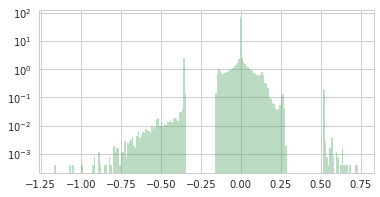

**Epoch: 18**

Layer Loss: -78432.867
Layer Loss: -258.444
Layer Loss: 4211.978
Layer Loss: -51.553
Layer Loss: 1838.585
Layer Loss: -8.840
0-neglogprop Loss: -28026.189
Remaining-neglogprop Loss: -22552.330
Epoch: 19. Loss: 1.6049127578735352. Accuracy: 95.81
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.087, -0.0, 0.087, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.357, -0.442, 0.44, 0.448, -0.093, -0.399, -0.383, -0.383, -0.383, -0.394, -0.108, -0.025, -0.504, -0.337, -0.377]
Precisions: [5.737, 5.644, 6.463, 5.645, 6.481, 5.767, 6.238, 6.434, 6.429, 6.433, 6.281, 6.364, 6.386, 6.426, 6.482, 6.443]


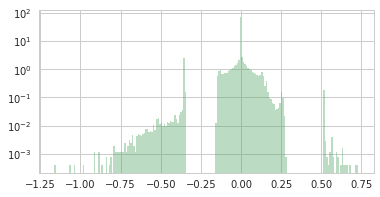

**Epoch: 19**

Layer Loss: -82545.469
Layer Loss: -261.996
Layer Loss: 3508.526
Layer Loss: -53.977
Layer Loss: 1808.482
Layer Loss: -8.987
0-neglogprop Loss: -28059.160
Remaining-neglogprop Loss: -22568.672
Epoch: 20. Loss: 1.6240347623825073. Accuracy: 95.68
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.087, -0.0, 0.087, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.368, -0.451, 0.448, 0.457, -0.103, -0.408, -0.391, -0.391, -0.391, -0.403, -0.118, -0.036, -0.513, -0.343, -0.386]
Precisions: [5.745, 5.639, 6.473, 5.636, 6.491, 5.763, 6.247, 6.442, 6.438, 6.442, 6.29, 6.374, 6.393, 6.435, 6.492, 6.452]


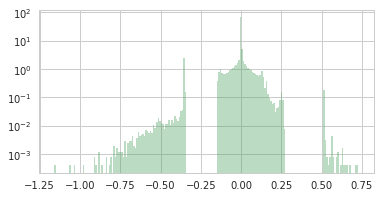

**Epoch: 20**

Layer Loss: -86591.648
Layer Loss: -265.531
Layer Loss: 2821.944
Layer Loss: -56.341
Layer Loss: 1779.158
Layer Loss: -9.130
0-neglogprop Loss: -28096.102
Remaining-neglogprop Loss: -22585.133
Epoch: 21. Loss: 1.6464635133743286. Accuracy: 95.55
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.087, -0.0, 0.087, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.378, -0.46, 0.456, 0.466, -0.114, -0.416, -0.4, -0.4, -0.4, -0.411, -0.128, -0.047, -0.521, -0.348, -0.394]
Precisions: [5.755, 5.635, 6.482, 5.628, 6.5, 5.76, 6.256, 6.451, 6.446, 6.45, 6.299, 6.383, 6.399, 6.444, 6.501, 6.461]


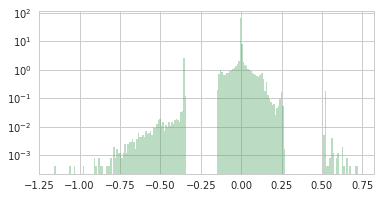

**Epoch: 21**

Layer Loss: -90579.414
Layer Loss: -269.051
Layer Loss: 2150.164
Layer Loss: -58.653
Layer Loss: 1750.520
Layer Loss: -9.270
0-neglogprop Loss: -28136.490
Remaining-neglogprop Loss: -22601.729
Epoch: 22. Loss: 1.6681015491485596. Accuracy: 95.35
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.087, -0.0, 0.087, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.389, -0.469, 0.464, 0.476, -0.124, -0.425, -0.408, -0.408, -0.408, -0.419, -0.138, -0.057, -0.53, -0.353, -0.403]
Precisions: [5.765, 5.631, 6.492, 5.62, 6.51, 5.757, 6.265, 6.46, 6.455, 6.459, 6.308, 6.392, 6.406, 6.454, 6.51, 6.47]


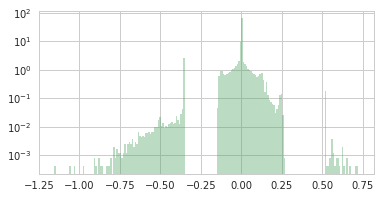

**Epoch: 22**

Layer Loss: -94514.578
Layer Loss: -272.553
Layer Loss: 1491.466
Layer Loss: -60.918
Layer Loss: 1722.489
Layer Loss: -9.407
0-neglogprop Loss: -28179.830
Remaining-neglogprop Loss: -22618.457
Epoch: 23. Loss: 1.692262887954712. Accuracy: 95.13
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.087, -0.0, 0.087, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.4, -0.479, 0.472, 0.485, -0.135, -0.433, -0.417, -0.417, -0.417, -0.428, -0.147, -0.068, -0.538, -0.359, -0.412]
Precisions: [5.775, 5.627, 6.501, 5.611, 6.52, 5.754, 6.274, 6.469, 6.464, 6.468, 6.317, 6.402, 6.413, 6.463, 6.52, 6.479]


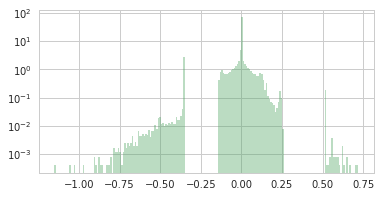

**Epoch: 23**

Layer Loss: -98401.328
Layer Loss: -276.037
Layer Loss: 844.430
Layer Loss: -63.141
Layer Loss: 1695.005
Layer Loss: -9.541
0-neglogprop Loss: -28225.670
Remaining-neglogprop Loss: -22635.320
Epoch: 24. Loss: 1.7171343564987183. Accuracy: 94.87
Means: [-0.601, -0.514, -0.427, -0.344, -0.258, -0.172, -0.087, -0.0, 0.087, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.411, -0.488, 0.48, 0.495, -0.145, -0.442, -0.425, -0.425, -0.425, -0.436, -0.157, -0.079, -0.547, -0.364, -0.42]
Precisions: [5.786, 5.624, 6.511, 5.604, 6.529, 5.752, 6.283, 6.478, 6.473, 6.477, 6.326, 6.411, 6.42, 6.472, 6.529, 6.489]


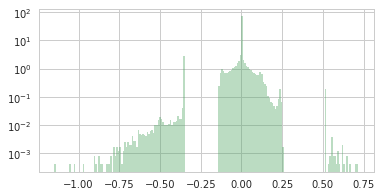

**Epoch: 24**

Layer Loss: -102242.531
Layer Loss: -279.499
Layer Loss: 207.921
Layer Loss: -65.325
Layer Loss: 1668.022
Layer Loss: -9.672
0-neglogprop Loss: -28273.607
Remaining-neglogprop Loss: -22652.324
Epoch: 25. Loss: 1.7430676221847534. Accuracy: 94.67
Means: [-0.601, -0.514, -0.427, -0.344, -0.259, -0.172, -0.087, -0.0, 0.087, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.422, -0.497, 0.488, 0.504, -0.156, -0.45, -0.434, -0.433, -0.434, -0.445, -0.167, -0.089, -0.555, -0.369, -0.429]
Precisions: [5.798, 5.621, 6.52, 5.596, 6.539, 5.751, 6.292, 6.486, 6.482, 6.486, 6.335, 6.42, 6.427, 6.481, 6.538, 6.498]


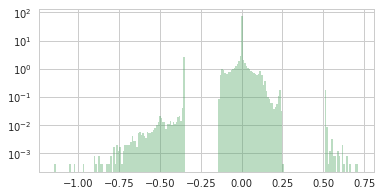

**Epoch: 25**

Layer Loss: -106040.164
Layer Loss: -282.936
Layer Loss: -418.977
Layer Loss: -67.474
Layer Loss: 1641.499
Layer Loss: -9.799
0-neglogprop Loss: -28323.295
Remaining-neglogprop Loss: -22669.467
Epoch: 26. Loss: 1.7700437307357788. Accuracy: 94.41
Means: [-0.601, -0.514, -0.427, -0.344, -0.259, -0.172, -0.087, -0.0, 0.087, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.433, -0.507, 0.496, 0.513, -0.167, -0.458, -0.442, -0.442, -0.442, -0.453, -0.177, -0.1, -0.563, -0.373, -0.438]
Precisions: [5.809, 5.618, 6.53, 5.588, 6.548, 5.749, 6.301, 6.495, 6.49, 6.494, 6.344, 6.429, 6.434, 6.491, 6.547, 6.507]


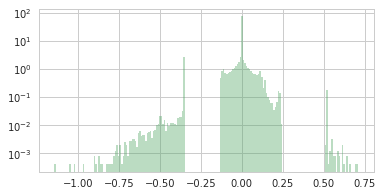

**Epoch: 26**

Layer Loss: -109795.484
Layer Loss: -286.347
Layer Loss: -1036.974
Layer Loss: -69.589
Layer Loss: 1615.408
Layer Loss: -9.924
0-neglogprop Loss: -28374.428
Remaining-neglogprop Loss: -22686.750
Epoch: 27. Loss: 1.7943449020385742. Accuracy: 94.14
Means: [-0.601, -0.514, -0.427, -0.344, -0.259, -0.172, -0.087, -0.0, 0.087, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.444, -0.516, 0.503, 0.523, -0.178, -0.467, -0.45, -0.45, -0.45, -0.462, -0.187, -0.11, -0.572, -0.378, -0.447]
Precisions: [5.822, 5.616, 6.539, 5.581, 6.558, 5.749, 6.31, 6.504, 6.499, 6.503, 6.353, 6.438, 6.441, 6.5, 6.557, 6.516]


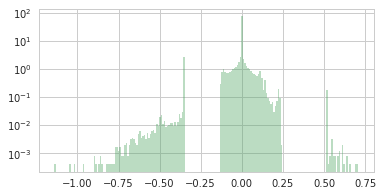

**Epoch: 27**

Layer Loss: -113509.344
Layer Loss: -289.729
Layer Loss: -1646.629
Layer Loss: -71.671
Layer Loss: 1589.727
Layer Loss: -10.045
0-neglogprop Loss: -28426.754
Remaining-neglogprop Loss: -22704.176
Epoch: 28. Loss: 1.8207956552505493. Accuracy: 93.81
Means: [-0.601, -0.514, -0.427, -0.344, -0.259, -0.172, -0.087, -0.0, 0.087, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.455, -0.525, 0.511, 0.532, -0.189, -0.475, -0.459, -0.459, -0.459, -0.47, -0.196, -0.12, -0.58, -0.383, -0.456]
Precisions: [5.834, 5.614, 6.548, 5.574, 6.568, 5.749, 6.318, 6.513, 6.508, 6.512, 6.362, 6.447, 6.448, 6.509, 6.566, 6.526]


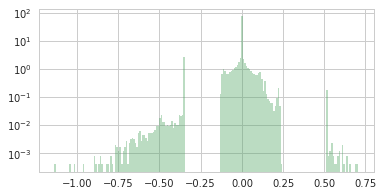

**Epoch: 28**

Layer Loss: -117182.023
Layer Loss: -293.080
Layer Loss: -2248.362
Layer Loss: -73.721
Layer Loss: 1564.437
Layer Loss: -10.163
0-neglogprop Loss: -28480.055
Remaining-neglogprop Loss: -22721.746
Epoch: 29. Loss: 1.8492072820663452. Accuracy: 93.43
Means: [-0.602, -0.514, -0.427, -0.344, -0.259, -0.172, -0.087, -0.0, 0.087, 0.172, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.466, -0.535, 0.518, 0.541, -0.2, -0.484, -0.467, -0.467, -0.467, -0.478, -0.206, -0.13, -0.589, -0.387, -0.464]
Precisions: [5.846, 5.612, 6.558, 5.568, 6.578, 5.749, 6.327, 6.521, 6.517, 6.52, 6.371, 6.456, 6.455, 6.518, 6.575, 6.535]


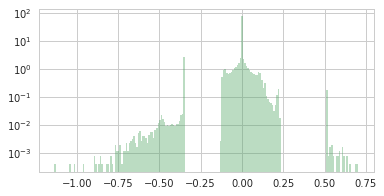

**Epoch: 29**

Layer Loss: -120813.688
Layer Loss: -296.398
Layer Loss: -2842.499
Layer Loss: -75.739
Layer Loss: 1539.523
Layer Loss: -10.278
0-neglogprop Loss: -28534.143
Remaining-neglogprop Loss: -22739.459
Epoch: 30. Loss: 1.8765857219696045. Accuracy: 93.16
Means: [-0.602, -0.514, -0.427, -0.344, -0.259, -0.172, -0.087, -0.0, 0.087, 0.173, 0.258, 0.342, 0.429, 0.515, 0.598]
Mixing Proportions: [-0.477, -0.544, 0.526, 0.551, -0.212, -0.492, -0.476, -0.475, -0.475, -0.487, -0.216, -0.14, -0.597, -0.391, -0.473]
Precisions: [5.859, 5.611, 6.567, 5.561, 6.587, 5.75, 6.336, 6.53, 6.525, 6.529, 6.38, 6.465, 6.462, 6.527, 6.585, 6.545]


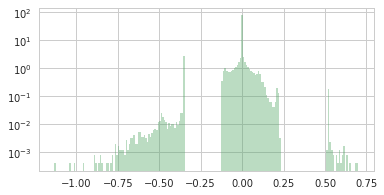

In [95]:
#model = models.LeNet_300_100().cuda()
#print_dims(model)
#model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, 100)).cuda()
#gmp = GaussianMixturePrior(16, [x for x in model.parameters()], 0.99)
sws_param2 = [gmp.gammas, gmp.rhos]
sws_param1 = [gmp.means]
ipd.display(ipd.Markdown("**Default Training**"))

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer_gmp = torch.optim.Adam(sws_param1, lr=1e-5)
optimizer_gmp2 = torch.optim.Adam(sws_param2, lr=3e-3)
graph_title='original_model/'

for epoch in range(30):
    ipd.display(ipd.Markdown("**Epoch: {}**".format(epoch)))
    model, loss = train_epoch_sws(model, optimizer, optimizer_gmp, optimizer_gmp2, criterion, train_loader)
    
    test_acc = test_accuracy(test_data_full, test_labels_full, model)
    train_acc = test_accuracy(train_data_full, train_labels_full, model)
    weight_penalty = get_weight_penalty(model)
    
    if(writeTensorboard):
        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
    if (trueAfterN(epoch, 1)):
        print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], test_acc[0]))
        print ( "Means: {}".format(list(np.around(gmp.means.data.clone().cpu().numpy(),3))) )
        print ( "Mixing Proportions: {}".format(list(np.around(gmp.rhos.data.clone().cpu().numpy(),3))) )
        print ( "Precisions: {}".format(list(np.around(gmp.gammas.data.clone().cpu().numpy(),3))) )
        show_all_weights(model)
    

#torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, training_epochs))

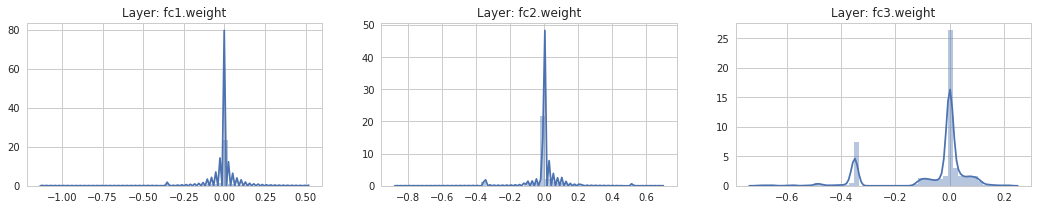

In [96]:
show_weights(model)

### 2. Re-train Model

**Temperature = 1**

Epoch: 20. Train CE Loss: 1.513, Train Accuracy: 99.037, Test CE Loss: 1.519, Test Accuracy: 97.990, Model L2: 18.815
Epoch: 40. Train CE Loss: 1.512, Train Accuracy: 99.055, Test CE Loss: 1.517, Test Accuracy: 98.040, Model L2: 18.733


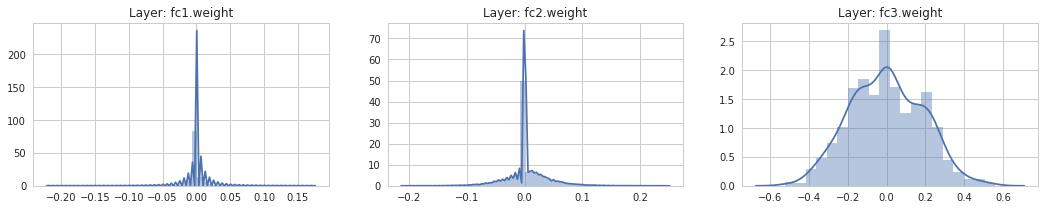

**Temperature = 5**

Epoch: 20. Train CE Loss: 1.516, Train Accuracy: 98.848, Test CE Loss: 1.522, Test Accuracy: 97.810, Model L2: 18.595
Epoch: 40. Train CE Loss: 1.514, Train Accuracy: 98.950, Test CE Loss: 1.520, Test Accuracy: 98.010, Model L2: 18.491


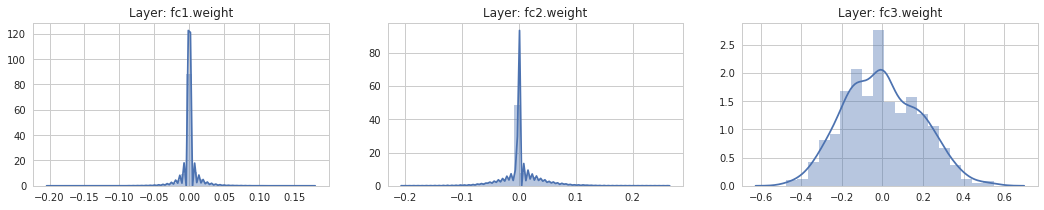

**Temperature = 10**

Epoch: 20. Train CE Loss: 1.531, Train Accuracy: 98.688, Test CE Loss: 1.534, Test Accuracy: 97.950, Model L2: 17.576
Epoch: 40. Train CE Loss: 1.529, Train Accuracy: 98.710, Test CE Loss: 1.532, Test Accuracy: 97.850, Model L2: 17.509


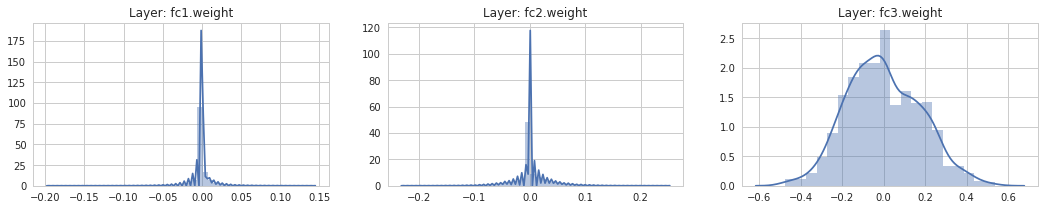

**Temperature = 15**

Epoch: 20. Train CE Loss: 1.576, Train Accuracy: 98.330, Test CE Loss: 1.575, Test Accuracy: 97.680, Model L2: 16.114
Epoch: 40. Train CE Loss: 1.575, Train Accuracy: 98.407, Test CE Loss: 1.575, Test Accuracy: 97.670, Model L2: 16.017


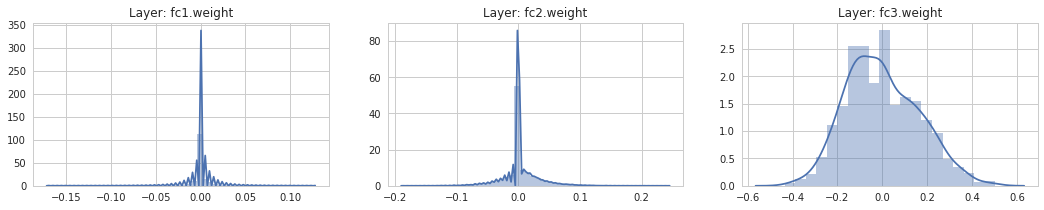

**Temperature = 20**

Epoch: 20. Train CE Loss: 1.648, Train Accuracy: 97.995, Test CE Loss: 1.645, Test Accuracy: 97.490, Model L2: 14.677
Epoch: 40. Train CE Loss: 1.648, Train Accuracy: 98.038, Test CE Loss: 1.644, Test Accuracy: 97.480, Model L2: 14.611


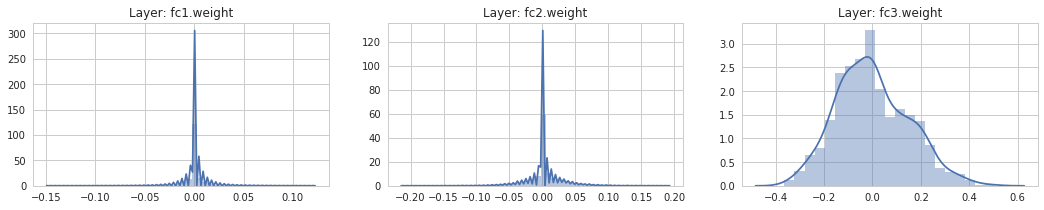

**Temperature = 25**

Epoch: 20. Train CE Loss: 1.729, Train Accuracy: 97.690, Test CE Loss: 1.724, Test Accuracy: 97.310, Model L2: 13.517
Epoch: 40. Train CE Loss: 1.727, Train Accuracy: 97.895, Test CE Loss: 1.722, Test Accuracy: 97.500, Model L2: 13.511


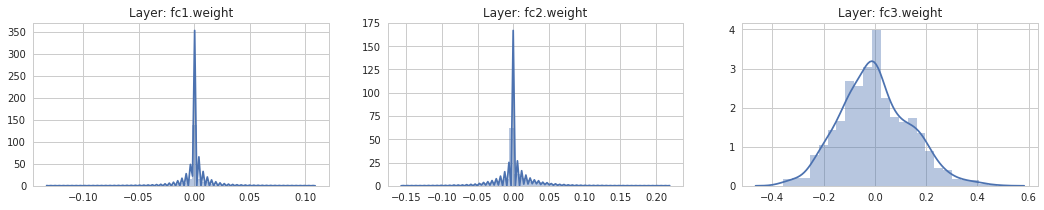

**Temperature = 30**

Epoch: 20. Train CE Loss: 1.806, Train Accuracy: 97.617, Test CE Loss: 1.800, Test Accuracy: 97.280, Model L2: 12.557
Epoch: 40. Train CE Loss: 1.806, Train Accuracy: 97.635, Test CE Loss: 1.801, Test Accuracy: 97.220, Model L2: 12.561


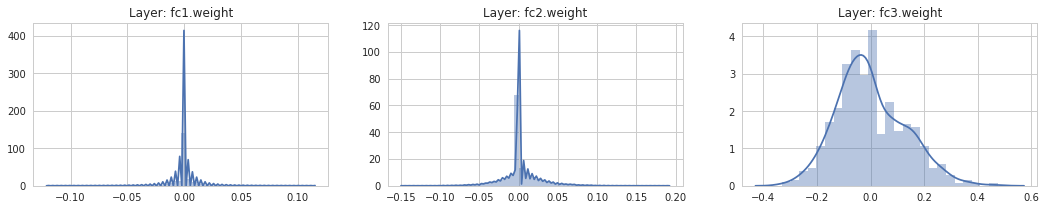

In [3]:
#Get KD Targets   
for temp in temp_list:
    ipd.display(ipd.Markdown("**Temperature = {}**".format(temp)))
    model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, training_epochs)).cuda()
    kd_outputs = model.kd_targets(train_data_full,T=temp)
    kd_dataset = torch.utils.data.TensorDataset(train_data_full.data, kd_outputs.data)#.data turns variable -> tensor
    train_kd_loader = torch.utils.data.DataLoader(dataset=kd_dataset, batch_size=batch_size, shuffle=True)

    #Load model
    model_kd = models.LeNet_300_100().cuda()
    model_kd.load_state_dict(model.state_dict())

    #Set up Optimisers and loss
    criterion_kd = nn.MSELoss()
    learning_rate_kd = 0.0005
    wd_kd = 0.0001
    optimizer_kd_1 = torch.optim.Adam(model_kd.fc1.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_2 = torch.optim.Adam(model_kd.fc2.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
    optimizer_kd_3 = torch.optim.Adam(model_kd.fc3.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)

    graph_title = "compressed_model_T_{}/".format(temp)

    for epoch in range(retraining_epochs):
        model_kd, loss = train_epoch(model_kd, optimizer_kd_3, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_2, criterion_kd, train_kd_loader)
        model_kd, loss = train_epoch(model_kd, optimizer_kd_1, criterion_kd, train_kd_loader)
        test_acc = test_accuracy(test_data_full, test_labels_full, model_kd)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_kd)
        weight_penalty = get_weight_penalty(model_kd)

        writer.add_scalars(graph_title + 'train_CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'train_Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'train_L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
        if (epoch%20==19):
            print('Epoch: {}. Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}'.format(epoch+1, train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty))
    torch.save(model_kd, model_dir + 'mnist_{}_kd_t{}_e{}.m'.format(model_kd.name, temp, retraining_epochs))
    show_weights(model_kd)

### 3. Prune Model

**Temperature = 1**

Train CE Loss: 1.862, Train Accuracy: 89.627, Test CE Loss: 1.857, Test Accuracy: 88.930, Model L2: 16.345, Parameters Pruned: 235301/266610 - 88.257%
Train CE Loss: 1.929, Train Accuracy: 85.725, Test CE Loss: 1.924, Test Accuracy: 84.600, Model L2: 16.124, Parameters Pruned: 226270/266610 - 84.869%


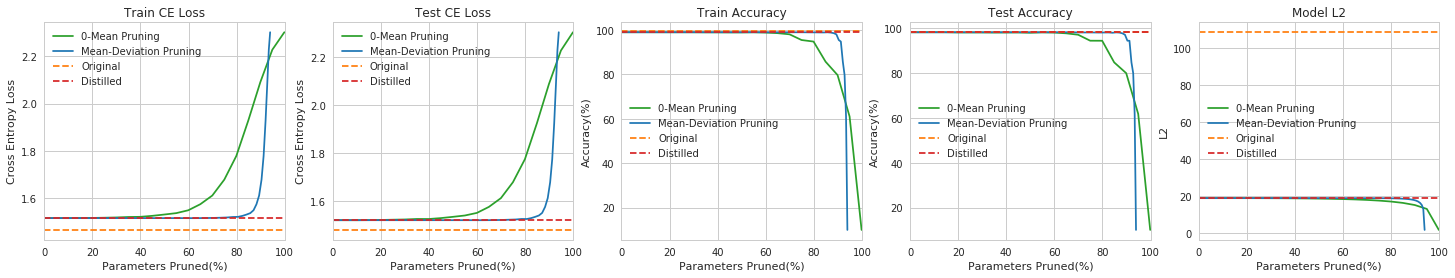

**Temperature = 5**

Train CE Loss: 1.848, Train Accuracy: 84.250, Test CE Loss: 1.844, Test Accuracy: 83.450, Model L2: 16.239, Parameters Pruned: 235622/266610 - 88.377%
Train CE Loss: 1.897, Train Accuracy: 82.622, Test CE Loss: 1.894, Test Accuracy: 81.950, Model L2: 15.949, Parameters Pruned: 226270/266610 - 84.869%


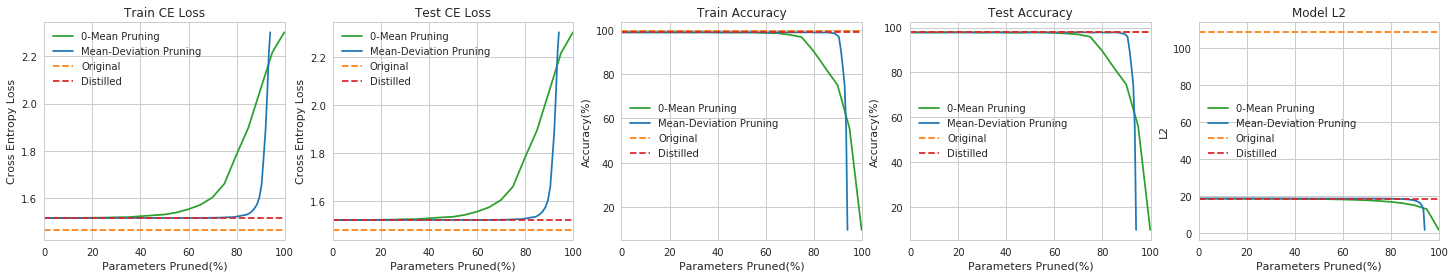

**Temperature = 10**

Train CE Loss: 1.869, Train Accuracy: 90.467, Test CE Loss: 1.861, Test Accuracy: 89.800, Model L2: 15.362, Parameters Pruned: 235608/266610 - 88.372%
Train CE Loss: 1.926, Train Accuracy: 92.660, Test CE Loss: 1.919, Test Accuracy: 91.990, Model L2: 15.180, Parameters Pruned: 226270/266610 - 84.869%


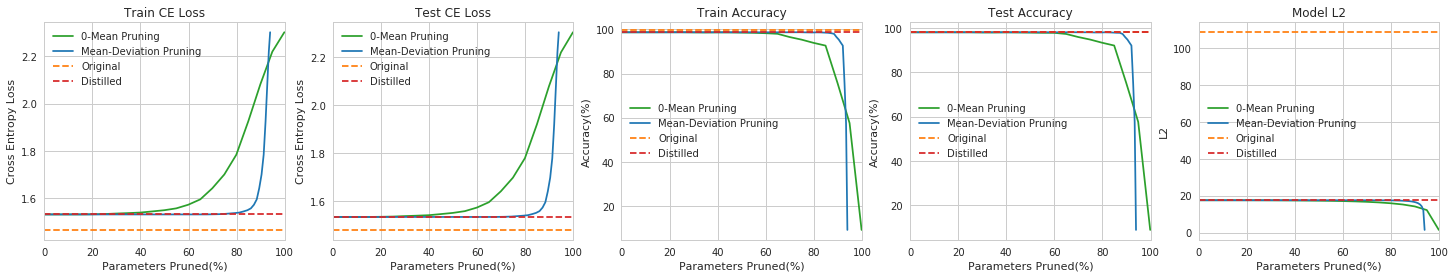

**Temperature = 15**

Train CE Loss: 1.928, Train Accuracy: 90.552, Test CE Loss: 1.922, Test Accuracy: 90.050, Model L2: 14.014, Parameters Pruned: 236170/266610 - 88.583%
Train CE Loss: 1.983, Train Accuracy: 84.900, Test CE Loss: 1.978, Test Accuracy: 84.110, Model L2: 13.849, Parameters Pruned: 226270/266610 - 84.869%


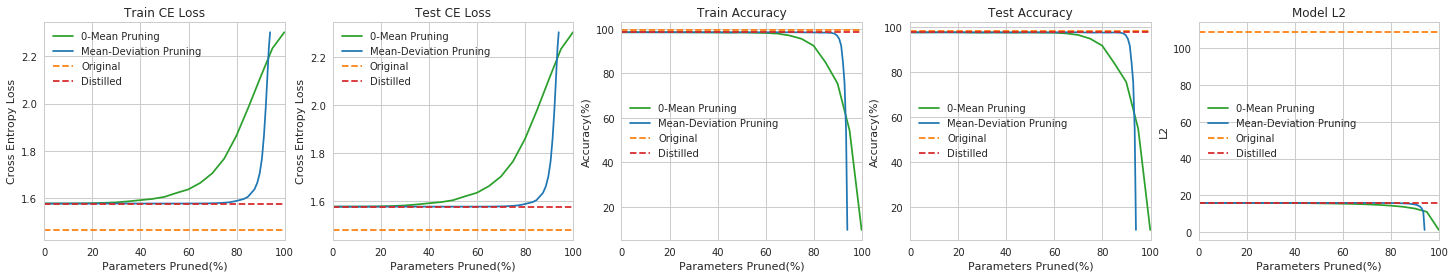

**Temperature = 20**

Train CE Loss: 1.981, Train Accuracy: 88.742, Test CE Loss: 1.975, Test Accuracy: 88.460, Model L2: 12.907, Parameters Pruned: 235772/266610 - 88.433%
Train CE Loss: 2.024, Train Accuracy: 87.882, Test CE Loss: 2.019, Test Accuracy: 87.350, Model L2: 12.730, Parameters Pruned: 226270/266610 - 84.869%


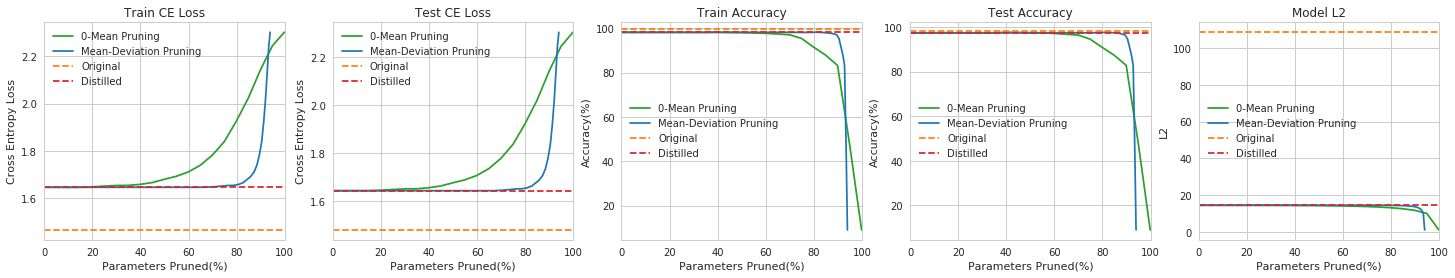

**Temperature = 25**

Train CE Loss: 2.031, Train Accuracy: 86.620, Test CE Loss: 2.025, Test Accuracy: 86.660, Model L2: 11.936, Parameters Pruned: 234994/266610 - 88.141%
Train CE Loss: 2.072, Train Accuracy: 83.885, Test CE Loss: 2.066, Test Accuracy: 83.910, Model L2: 11.764, Parameters Pruned: 226270/266610 - 84.869%


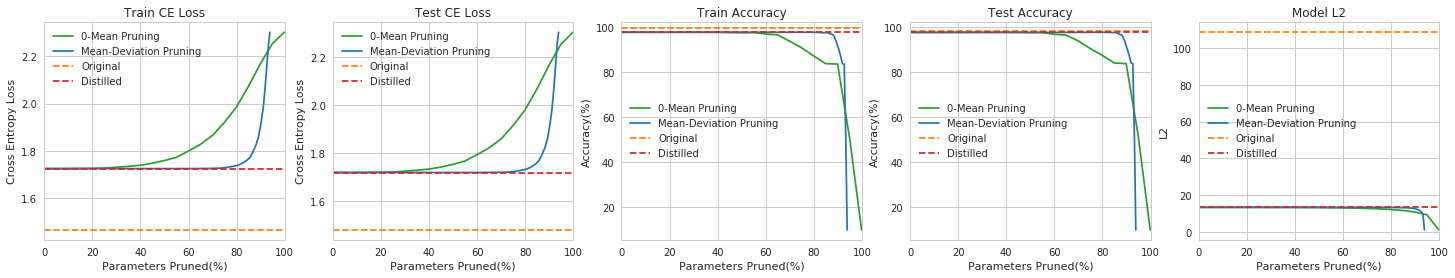

**Temperature = 30**

Train CE Loss: 2.100, Train Accuracy: 94.078, Test CE Loss: 2.096, Test Accuracy: 93.550, Model L2: 11.047, Parameters Pruned: 234621/266610 - 88.002%
Train CE Loss: 2.117, Train Accuracy: 88.603, Test CE Loss: 2.114, Test Accuracy: 88.120, Model L2: 10.959, Parameters Pruned: 226270/266610 - 84.869%


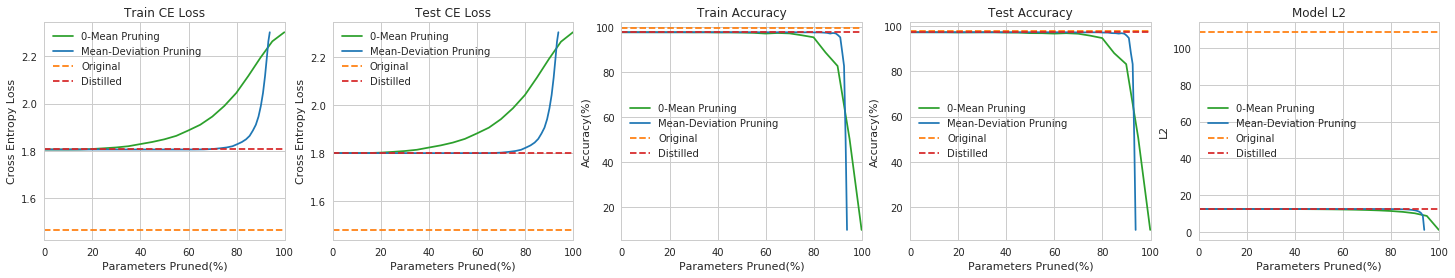

In [4]:
#Original Model
model = torch.load(model_dir + 'mnist_LeNet_300_100_100.m').cuda()
test_acc_o = test_accuracy(test_data_full, test_labels_full, model)
train_acc_o = test_accuracy(train_data_full, train_labels_full, model)
weight_penalty_o = get_weight_penalty(model)
compress_res = {}

for temp in temp_list:
    ipd.display(ipd.Markdown("**Temperature = {}**".format(temp)))
    graph_title = "compressed_model_T_{}/".format(temp)
    #Retrained Model
    model_kd = torch.load(model_dir + 'mnist_LeNet_300_100_kd_t{}_e50.m'.format(temp)).cuda()
    test_acc_kd = test_accuracy(test_data_full, test_labels_full, model_kd)
    train_acc_kd = test_accuracy(train_data_full, train_labels_full, model_kd)
    weight_penalty_kd = get_weight_penalty(model_kd)
    
    #writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Distilled Test': test_acc_kd[1], 'Distilled Train': train_acc_kd[1], 'Original Test': test_acc_o[1], 'Original Train': train_acc_o[1]}, 0)
    #writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Distilled Test': test_acc_kd[1], 'Distilled Train': train_acc_kd[1], 'Original Test': test_acc_o[1], 'Original Train': train_acc_o[1]}, 100)
    #writer.add_scalars(graph_title + 'Accuracy', {'Distilled Test': test_acc_kd[0], 'Distilled Train': train_acc_kd[0], 'Original Test': test_acc_o[0], 'Original Train': train_acc_o[0]}, 0)
    #writer.add_scalars(graph_title + 'Accuracy', {'Distilled Test': test_acc_kd[0], 'Distilled Train': train_acc_kd[0], 'Original Test': test_acc_o[0], 'Original Train': train_acc_o[0]}, 100)
    #writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 0)
    #writer.add_scalars(graph_title + 'L2', {'Distilled' : weight_penalty_kd, 'Original' : weight_penalty_o}, 100)
    
    model_c = models.LeNet_300_100().cuda()
    pruner = model_prune(model_kd.state_dict())
    deviation_list = [x/10.0 for x in range(0,21)]
    percentile_list = range(0,101,5)
    
    
    dev_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : []}
    for i,lim in enumerate(deviation_list):
        model_c.load_state_dict(pruner.deviation_prune(lim))
        test_acc = test_accuracy(test_data_full, test_labels_full, model_c)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_c)
        weight_penalty = get_weight_penalty(model_c)

        dev_res['train ce'].append(train_acc[1])
        dev_res['test ce'].append(test_acc[1])
        dev_res['train acc'].append(train_acc[0])
        dev_res['test acc'].append(test_acc[0])
        dev_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
        dev_res['L2'].append(weight_penalty)

        writer.add_scalars(graph_title + 'prune_CrossEntropyLoss', {'Deviation Test': test_acc[1], 'Deviation Train': train_acc[1]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_Accuracy', {'Deviation Test': test_acc[0], 'Deviation Train': train_acc[0]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_L2', {'Deviation': weight_penalty}, 100.0 * pruner.num_pruned/pruner.total_weights)

        if(i==13):
            print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
              .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))
    
    perc_res = {'train ce' : [], 'test ce' : [], 'train acc' : [], 'test acc' : [], 'pruned' : [], 'L2' : [],} 
    for i,lim in enumerate(percentile_list):
        model_c.load_state_dict(pruner.percentile_prune(lim))

        test_acc = test_accuracy(test_data_full, test_labels_full, model_c)
        train_acc = test_accuracy(train_data_full, train_labels_full, model_c)
        weight_penalty = get_weight_penalty(model_c)
        perc_res['train ce'].append(train_acc[1])
        perc_res['test ce'].append(test_acc[1])
        perc_res['train acc'].append(train_acc[0])
        perc_res['test acc'].append(test_acc[0])
        perc_res['pruned'].append(100.0 * pruner.num_pruned/pruner.total_weights)
        perc_res['L2'].append(weight_penalty)

        writer.add_scalars(graph_title + 'prune_CrossEntropyLoss', {'Percentile Test': test_acc[1], 'Percentile Train': train_acc[1]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_Accuracy', {'Percentile Test': test_acc[0], 'Percentile Train': train_acc[0]}, 100.0 * pruner.num_pruned/pruner.total_weights)
        writer.add_scalars(graph_title + 'prune_L2', {'Percentile': weight_penalty}, 100.0 * pruner.num_pruned/pruner.total_weights)
        
        if(i==17):
            print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
              .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))
            
    prune_plot(temp, dev_res, perc_res, test_acc_o, train_acc_o, weight_penalty_o, test_acc_kd, train_acc_kd, weight_penalty_kd)
    #t_res={} 
    #t_res['dev']=dev_res
    #t_res['perc']=perc_res
    #compress_res[temp]=t_res